In [1]:
import pandas as pd
import numpy as np
import cv2
import os

from imutils import face_utils
import numpy as np
import argparse
import imutils

import dlib
import cv2
import matplotlib.pyplot as plt

In [1]:
'''
Process Dataset:

1. Detect Faces
2. Count Frames
3. Callibrate corresponding videos:
    i. Match driver view, road view and original videos to get the same number of frames in each.
    ii. Calibrate_videos
        -- count total number of frames in each video using count frames.
        -- use(drop = larger_frame_count/diff) to get equal number of frames in each video
        -- dnt write the frame of the videos at drop location in larger videos
4. Make explicit face points and driver_view_cropped2
5. Driver crop videos:  using dlib face detector find out x,y,w,h and crop the videos
6. Explicit face points:x,y, x+w+n, y+h+n
7. Run this on all the videos

'''

'\nProcess Dataset:\n\n1. Detect Faces\n2. Count Frames\n3. Callibrate corresponding videos:\n    i. Match driver view, road view and original videos to get the same number of frames in each.\n    ii. Calibrate_videos\n        -- count total number of frames in each video using count frames.\n        -- use(drop = larger_frame_count/diff) to get equal number of frames in each video\n        -- dnt write the frame of the videos at drop location in larger videos\n4. Make explicit face points and driver_view_cropped2\n5. Driver crop videos:  using dlib face detector find out x,y,w,h and crop the videos\n6. Explicit face points:x,y, x+w+n, y+h+n\n7. Run this on all the videos\n\n'

In [2]:
def detect_face(img, n):
    
    # initialize dlib's face detect or (HOG-based) and then create
    # the facial landmark predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor.dat")
    
    # load the input image, resize it, and convert it to grayscale
    #image = cv2.imread(img)
    image = img
#     image = imutils.resize(image, width=500)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # detect faces in the grayscale image
    rects = detector(gray, 1)
    
    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)], then draw the face bounding box
        (x, y, w, h) = face_utils.rect_to_bb(rect)
#         cv2.rectangle(image, (x-n, y-n), (x + w+n, y + h+n), (255, 255, 255), 6)

#         # show the face number
# #         cv2.putText(image, "Face #{}".format(i + 1), (x - 10, y - 10),
# #             cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

#         # loop over the (x, y)-coordinates for the facial landmarks
#         # and draw them on the image
#         for (x, y) in shape:
#             cv2.circle(image, (x, y), 4, (255, 255, 255), -1)
            
        
#         plt.imshow(image)
#         plt.show()
        return x,y,w,h



In [3]:
def count_frames(video):
    count = 0
    vid = cv2.VideoCapture(video)    
    while(True):
        ret, frame = vid.read()
        if(ret == False):
            break
        count += 1
        
    return count

In [4]:
def callibrate_corresponding_videos(video1, video2, video3, textfile, output_vid1, output_vid2, output_vid3, 
                                    out_textfile, n1):
    
    print("############################################################")
    print("sample_" +str(n1))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    
    if(n1>=10):
        file1 = pd.read_csv(textfile, header = None).values
        print(textfile,file1.shape)
    else:
        file1 = np.load(textfile)
        print(textfile,file1.shape)
    
    arr = [];
    
    #################################################################################################
    out1 = cv2.VideoWriter(output_vid1, fourcc, 25, (1440,1080)) ### driver
    out2 = cv2.VideoWriter(output_vid2, fourcc, 25, (1440,1080)) ### road
    out3 = cv2.VideoWriter(output_vid3, fourcc, 25, (1920, 1080)) ### original
    
    #################################################################################################
    cap1 = cv2.VideoCapture(video1)###### driver ###################
    frame_count1 = count_frames(video1)
    
    cap2 = cv2.VideoCapture(video2)###### road ####################
    frame_count2 = count_frames(video2)
    
    cap3 = cv2.VideoCapture(video3)###### Original ####################
    frame_count3 = count_frames(video3)
    
    #print(frame_count1, frame_count2, frame_count3)

    #################################################################################################
    i = 0; count = 0; flag =0

    if(frame_count2 == frame_count3):
        flag =1
        n = frame_count2
        first = frame_count2
        second = frame_count3

    elif(frame_count3 < frame_count2):
        n = frame_count2
        first = frame_count2
        second = frame_count3

    elif(frame_count3 > frame_count2):
        n = frame_count3
        first = frame_count3
        second = frame_count2

    diff = first - second
    if(diff != 0):
        drop = np.round(first/diff)
        print(n, drop, first, second, diff)
    k =0
    #print(file1)
    while(i < n):
        if(flag == 0):
            if(diff != 0 and i%drop == 0 ):
               # print(i)
                if(frame_count2 > frame_count3):
                    ret2, frame2 = cap2.read()
                    ret1, frame1 = cap1.read()

                else:
                    ret3, frame3 = cap3.read()
                   # print(i)
                    k +=1
            else:
                count += 1
               # print(k)
                ret1, frame1 = cap1.read()
                ret2, frame2 = cap2.read()
                ret3, frame3 = cap3.read()
                if(ret2 == False or ret3 == False):
                    break
                arr.append(file1[k])
                k +=1

                #print(frame1.shape, frame2.shape, frame3.shape)
              #  frame2 = cv2.resize(frame2, (692, 460))
              #  print(frame1.shape, frame2.shape)
                #print(ret1, ret2)
    #             if(ret2 == False or ret3 == False):
    #                 break
             #   frame3 = np.concatenate((frame1, frame2), axis =1)
                out1.write(frame1)
                out2.write(frame2)
                out3.write(frame3)

            i += 1
            
        elif(flag ==1):
            count += 1
            ret1, frame1 = cap1.read()
            ret2, frame2 = cap2.read()
            ret3, frame3 = cap3.read()
            if(ret2 == False or ret3 == False):
                break
            arr.append(file1[k])
            k +=1

            out1.write(frame1)
            out2.write(frame2)
            out3.write(frame3)

            i += 1
        
    print(first, second, count, np.array(arr).shape)
    
    arr = np.array(arr)
    np.save(out_textfile, arr)
        
    out1.release(); out2.release(); out3.release()
    cap1.release(); cap2.release(); cap3.release()
        
    

In [5]:
def call_callibrate_corresponding_videos(ur):

    directory1 = "dataset_samples_callibrated/user"+str(ur)
    if not os.path.exists(directory1):
        os.makedirs(directory1)
        
    directory2 = "dataset_samples_callibrated/user"+str(ur)+"/driver_view"
    if not os.path.exists(directory2):
        os.makedirs(directory2)
        
    directory3 = "dataset_samples_callibrated/user"+str(ur)+"/road_view"
    if not os.path.exists(directory3):
        os.makedirs(directory3)
        
    directory4 = "dataset_samples_callibrated/user"+str(ur)+"/original_road_view"
    if not os.path.exists(directory4):
        os.makedirs(directory4)
        
    for i in range(0,112):
  
        video1 = "dataset_samples/user"+str(ur)+"/driver_view/sample"+str(i+1)+".avi"            
        video2 = "dataset_samples/user"+str(ur)+"/road_view/sample"+str(i+1)+".avi"
        video3 = "original_samples2/trip"+str(i+1)+"_out_hist.avi"

        if(i+1 < 10):
            textfile = "original_samples2/trip"+str(i+1)+"_out.npy"
        else:
            textfile = "original_samples2/trip"+str(i+1)+"_out.txt"


        out_video1 = directory2 + "/sample_"+str(i+1)+".avi"
        out_video2 = directory3 + "/sample_"+str(i+1)+".avi"
        out_video3 = directory4 + "/sample_"+str(i+1)+".avi"
        out_textfile = directory4 + "/sample_"+str(i+1)+".npy"

        callibrate_corresponding_videos(video1, video2, video3, textfile, out_video1, out_video2, out_video3, out_textfile, i+1)

In [6]:
# call_callibrate_corresponding_videos(2)

In [9]:
call_callibrate_corresponding_videos(23)

############################################################3
sample_1
original_samples2/trip1_out.npy (100, 2)
113 9.0 113 100 13
113 100 100 (100, 2)
############################################################3
sample_2
original_samples2/trip2_out.npy (100, 2)
112 9.0 112 100 12
112 100 99 (99, 2)
############################################################3
sample_3
original_samples2/trip3_out.npy (100, 2)
114 8.0 114 100 14
114 100 99 (99, 2)
############################################################3
sample_4
original_samples2/trip4_out.npy (100, 2)
115 8.0 115 100 15
115 100 100 (100, 2)
############################################################3
sample_5
original_samples2/trip5_out.npy (100, 2)
103 34.0 103 100 3
103 100 99 (99, 2)
############################################################3
sample_6
original_samples2/trip6_out.npy (100, 2)
115 8.0 115 100 15
115 100 100 (100, 2)
############################################################3
sample_7
original_samples2/trip7

127 4.0 127 92 35
127 92 93 (92, 5)
############################################################3
sample_56
original_samples2/trip56_out.txt (121, 5)
154 5.0 154 121 33
154 121 122 (121, 5)
############################################################3
sample_57
original_samples2/trip57_out.txt (42, 5)
68 3.0 68 42 26
68 42 43 (42, 5)
############################################################3
sample_58
original_samples2/trip58_out.txt (118, 5)
160 4.0 160 118 42
160 118 119 (118, 5)
############################################################3
sample_59
original_samples2/trip59_out.txt (64, 5)
97 3.0 97 64 33
97 64 64 (64, 5)
############################################################3
sample_60
original_samples2/trip60_out.txt (68, 5)
100 3.0 100 68 32
100 68 66 (66, 5)
############################################################3
sample_61
original_samples2/trip61_out.txt (45, 5)
71 3.0 71 45 26
71 45 46 (45, 5)
############################################################3
sample_

243 6.0 243 202 41
243 202 202 (202, 5)
############################################################3
sample_110
original_samples2/trip110_out.txt (216, 5)
260 6.0 260 216 44
260 216 216 (216, 5)
############################################################3
sample_111
original_samples2/trip111_out.txt (179, 5)
179 7.0 179 152 27
179 152 153 (152, 5)
############################################################3
sample_112
original_samples2/trip112_out.txt (178, 5)
178 2.0 178 105 73
178 105 89 (89, 5)


y


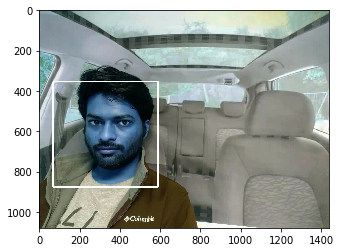

In [10]:
ur = 15

for i in range(1):
    videofile = "dataset_samples_callibrated/user"+str(ur)+"/driver_view/sample_" +str(i+1)+".avi"
    vid  = cv2.VideoCapture(videofile)
    if(os.path.exists(videofile)):
        print('y')
    else:
        print('n')
    while(True):
        ret, frame = vid.read()
        if(ret == False):
            break
        n =100
        x,y,w,h = detect_face(frame, 100)
        x1 = x-n; y1= y-n
        if(x1 <=0):
            x1 =0
        if(y1 <= 0):
            y1 = 0
        cv2.rectangle(frame, (x1, y1), (x + w+n, y + h+n), (255, 255, 255), 6)
        frame1 = frame[ y1:y+h+n, x1:x+w+n]
        plt.imshow(frame)
        plt.show()
        break
        

In [7]:
def crop_driver_video(videofile, destination_video,destination_file, n):
    
    vid  = cv2.VideoCapture(videofile)
    i  =0; flag =0; arr = []
    if(os.path.exists(videofile)):
        
        while(True):
            temp = []
            ret, frame = vid.read()
            if(ret == False):
                flag =1
                break

            if(i ==0):
                x,y,w,h = detect_face(frame, n)
                x1 = x-n; y1= y-n
                if(x1 <=0):
                    x1 =0
                if(y1 <= 0):
                    y1 = 0
                
                fourcc = cv2.VideoWriter_fourcc(*'XVID')
                out = cv2.VideoWriter(destination_video,fourcc, 21, (x+w+n-x1,y+h+n-y1))

                

                #cv2.rectangle(frame, (x1, y1), (x + w+n, y + h+n), (255, 255, 255), 6)
        
            frame1 = frame[y1:y+h+n, x1:x+w+n]
            temp.append(y1)
            temp.append(y+h+n)
            temp.append(x1)
            temp.append(x+w+n)
            arr.append(temp)
            #print(frame1.shape)
            #print(frame.shape, frame1.shape)
            #print(i, w+2*n,h+2*n)
          #  cv2.rectangle(image, (x-n, y-n), (x + w+n, y + h+n), (255, 255, 255), 6)
            out.write(frame1)
            i +=1
        np.save(destination_file, np.array(arr))
        if(flag ==0):
            out.release()
            vid.release()
            
        else:
            print(i)
        

    

In [10]:
def call_crop_driver_video(ur):
    directory1 = "dataset_samples_callibrated/user"+str(ur)+"/driver_view_cropped2/"
    directory2 = "dataset_samples_callibrated/user"+str(ur)+"/explicit_face_points/"
    if not os.path.exists(directory1):
        os.makedirs(directory1)
    
    if not os.path.exists(directory2):
        os.makedirs(directory2)
        
    for i in range(1,112):
        print("user"+str(ur), "sample_" +str(i+1)+".avi")
        video_filename = "dataset_samples_callibrated/user"+str(ur)+"/driver_view/sample_" +str(i+1)+".avi"
        crop_driver_video(video_filename, directory1 +"sample_" + str(i+1)+".avi", directory2 +"sample_" + str(i+1)+"_face_points.npy",100)

In [17]:
call_crop_driver_video(17)

user17 sample_1.avi
99
user17 sample_2.avi
99
user17 sample_3.avi
80
user17 sample_4.avi
100
user17 sample_5.avi
100
user17 sample_6.avi
99
user17 sample_7.avi
100
user17 sample_8.avi
99
user17 sample_9.avi
99
user17 sample_10.avi
63
user17 sample_11.avi
112
user17 sample_12.avi
82
user17 sample_13.avi
84
user17 sample_14.avi
75
user17 sample_15.avi
95
user17 sample_16.avi
80
user17 sample_17.avi
70
user17 sample_18.avi
86
user17 sample_19.avi
49
user17 sample_20.avi
147
user17 sample_21.avi
133
user17 sample_22.avi
115
user17 sample_23.avi
80
user17 sample_24.avi
132
user17 sample_25.avi
47
user17 sample_26.avi
141
user17 sample_27.avi
148
user17 sample_28.avi
91
user17 sample_29.avi
114
user17 sample_30.avi
76
user17 sample_31.avi
59
user17 sample_32.avi
73
user17 sample_33.avi
91
user17 sample_34.avi
129
user17 sample_35.avi
105
user17 sample_36.avi
123
user17 sample_37.avi
92
user17 sample_38.avi
165
user17 sample_39.avi
139
user17 sample_40.avi
117
user17 sample_41.avi
152
user17 

In [11]:
call_crop_driver_video(21)

user21 sample_2.avi
100
user21 sample_3.avi
98
user21 sample_4.avi
100
user21 sample_5.avi
95
user21 sample_6.avi
85
user21 sample_7.avi
83
user21 sample_8.avi
90
user21 sample_9.avi
87
user21 sample_10.avi
64
user21 sample_11.avi
56
user21 sample_12.avi
84
user21 sample_13.avi
84
user21 sample_14.avi
77
user21 sample_15.avi
80
user21 sample_16.avi
80
user21 sample_17.avi
70
user21 sample_18.avi
77
user21 sample_19.avi
44
user21 sample_20.avi
58
user21 sample_21.avi
130
user21 sample_22.avi
111
user21 sample_23.avi
78
user21 sample_24.avi
83
user21 sample_25.avi
135
user21 sample_26.avi
136
user21 sample_27.avi
132
user21 sample_28.avi
91
user21 sample_29.avi
99
user21 sample_30.avi
76
user21 sample_31.avi
63
user21 sample_32.avi
65
user21 sample_33.avi
72
user21 sample_34.avi
83
user21 sample_35.avi
107
user21 sample_36.avi
83
user21 sample_37.avi
94
user21 sample_38.avi
78
user21 sample_39.avi
124
user21 sample_40.avi
108
user21 sample_41.avi
103
user21 sample_42.avi
132
user21 sampl